# Homework 5

## FINM 33150 - 2024

### UChicago Financial Mathematics

* Haoran Ed Tian
* 12375851
* edmundht@uchicago.edu

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as spq
import quandl
import functools
import seaborn as sns
import plotnine as p9p
import datetime
import quandl
import nasdaqdatalink as ndl

from datetime import datetime
from itertools import permutations 
import statsmodels.api as sm

EdmundTianPrivateKeys = "ExgsXw1w4JfmPU4YodLQ"
quandl.ApiConfig.api_key = EdmundTianPrivateKeys

### 1 Introduction

An FX carry strategy borrows in a (low-interest-rate) currency and lends in another currency (with high interest rates). In this project we are going to replicate a float-for-fix cross-currency swap to take advantage of this mechanism. 

### 2 Data Preparation 
#### 2.1 Yield curves / spot curves extracted from swap rates of other countries. 
These are going to be used as lending rates in the strategy execution section. For convenience I stored yield curves for each currency in *{currency}__swap_yield_dict* where spot rates can be accessed by referencing specific years and zero coupon bond rates in *{currency}_swap_zcb_dict* in the same manner.

In [2]:
IYC = pd.read_csv('InferredYieldCurves_2024.tab', delimiter='\t')

def get_swap_yield(shortname_in):
    period_map = {'10Y': 10.0, '5Y': 5.0, '1Y': 1.0, '6M': 0.5}

    swap_yield = IYC[IYC['shortname'] == shortname_in]
    swap_yield['tenor'] = swap_yield['tenor'].map(period_map)
    swap_yield = swap_yield[['yield', 'date', 'tenor']]
    swap_yield['date'] = pd.to_datetime(swap_yield['date'])
    
    return swap_yield

In [3]:
def spot_rate(zcb, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        sr = None
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        coupons_pv_x = 0.5*np.exp(-r*times).sum()
        final_pv = np.exp(-tenor*r[-1])
        sr = (1.0 - final_pv) / coupons_pv_x # Solves x + c * delta = 1.0
    return sr
def compute_spot_rates(zcb_rates):
    spot = zcb_rates.copy()
    for curve in zcb_rates.columns:
        zcb = zcb_rates[curve]
        for tenor, rate in zcb.iteritems():
            if tenor>0.001:
                spot[curve][tenor] = spot_rate(zcb, tenor)
    return spot


In [4]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_half_yr*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_half_yr))/tenor
    return zcb_rates

In [5]:
def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p


In [8]:
EGP_swap_yield = get_swap_yield('Arab Rep Egypt').fillna(method='ffill')
HUF_swap_yield = get_swap_yield('Hungary').fillna(method='ffill')
CRC_swap_yield = get_swap_yield('Rep Costa Rica').fillna(method='ffill')
RON_swap_yield = get_swap_yield('Romania').fillna(method='ffill')

EGP_swap_yield_dict = {date.strftime("%Y-%m-%d"): group.drop('date', axis = 1).set_index('tenor')[::-1] for date, group in EGP_swap_yield.groupby('date')}
HUF_swap_yield_dict = {date.strftime("%Y-%m-%d"): group.drop('date', axis = 1).set_index('tenor')[::-1] for date, group in HUF_swap_yield.groupby('date')}
CRC_swap_yield_dict = {date.strftime("%Y-%m-%d"): group.drop('date', axis = 1).set_index('tenor')[::-1] for date, group in CRC_swap_yield.groupby('date')}
RON_swap_yield_dict = {date.strftime("%Y-%m-%d"): group.drop('date', axis = 1).set_index('tenor')[::-1] for date, group in RON_swap_yield.groupby('date')}

EGP_swap_zcb_dict = {date: compute_zcb_curve(swap_yield).rename(columns={'yield': 'ZCB'}) for date, swap_yield in EGP_swap_yield_dict.items()}
HUF_swap_zcb_dict = {date: compute_zcb_curve(swap_yield).rename(columns={'yield': 'ZCB'}) for date, swap_yield in HUF_swap_yield_dict.items()}
CRC_swap_zcb_dict = {date: compute_zcb_curve(swap_yield).rename(columns={'yield': 'ZCB'}) for date, swap_yield in CRC_swap_yield_dict.items()}
RON_swap_zcb_dict = {date: compute_zcb_curve(swap_yield).rename(columns={'yield': 'ZCB'}) for date, swap_yield in RON_swap_yield_dict.items()}

/var/folders/zq/3znm38ld5sq9yk3f706q0l9r0000gp/T/ipykernel_27392/2096819998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/zq/3znm38ld5sq9yk3f706q0l9r0000gp/T/ipykernel_27392/2096819998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/var/folders/zq/3znm38ld5sq9yk3f706q0l9r0000gp/T/ipykernel_27392/2096819998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

#### 2.2 Foreign Exchange Spot rates
The trading strategy requires rebalancing at the end of each week. Here we obtained as many foregin exchange spot rates during the interested time frame as possible.

In [10]:
def get_fx(curr_codes):
    fx = pd.DataFrame()
    for code in curr_codes:
        fx_new = quandl.get_table('EDI/CUR', code = code)
        fx_new = fx_new[(fx_new['date'] >= '2010-01-04')][::-1]
        fx_new.set_index('date', inplace = True)
        fx[code] = fx_new['rate']
        fx.rename(columns={code: 'USD{}'.format(code)}, inplace=True)
        
    return fx

In [17]:
currency_names = ['GBP', 'EGP','HUF','CRC','RON']
fx = get_fx(currency_names)
fx

,USDGBP,USDEGP,USDHUF,USDCRC,USDRON
date,,,,,
2010-01-04,0.620480,5.486981,187.200587,559.290882,2.933135
2010-01-05,0.624472,5.465845,186.364631,559.418301,2.903328
2010-01-06,0.625042,5.454573,187.136627,560.918803,2.895457
2010-01-07,0.628319,5.451902,188.842566,558.428865,2.915677
2010-01-08,0.625042,5.449738,187.893018,558.084731,2.914286
...,...,...,...,...,...
2024-03-03,0.790077,30.900000,363.620000,511.759601,4.584100
2024-03-04,0.789744,30.864100,363.262052,510.970821,4.585700
2024-03-05,0.788425,30.894900,364.462547,514.375402,4.581500


#### 2.3 Overnight Index Swaps
Capital will be converted to GBP first before more can be raised at the borrowing rates of OIS + 50 bps.

In [12]:
OIS = pd.read_csv('Bank of England  Database.csv')
OIS['Date'] = pd.to_datetime(OIS['Date'])
OIS.set_index('Date', inplace=True)
OIS.columns = ['IUDSOIA']
OIS = OIS[:0:-1]
OIS['IUDSOIA'] *= 0.01
OIS

,IUDSOIA
Date,
2010-01-04,0.004487
2010-01-05,0.004514
2010-01-06,0.004534
2010-01-07,0.004541
2010-01-08,0.004546
...,...
2024-02-20,0.051879
2024-02-21,0.051880
2024-02-22,0.051888


### 3 Trading Strategy
The carry trade strategy can be disected into several steps as reflected in the following function. After specifying start dates, end dates and relevant rates dataframes, I specify a range of hollidays when OIS will not be available and therefore should be ignored during the trading process. We assume positions will maintain during those days.

On the borrowing leg, at the start of week **Borrowed Amount (USD) - Start** will be the difference between leveraged capital and orignal capital. Using continuous compounding, **borrow_leg_interest_GBP** will be calculated and as are  **borrow_leg_interest_USD** and **Borrowed Amount (USD) - End** by the end of the week using updated USDGBP spot rate.

On the lending leg, **Notional** will be used as the starting **lending_amount_orig** which will be converted to **lending_amount_fx** with the starting FX spot rate. We assume the lending position is initiated by buying a $Z(t, t + 5 yrs, c = \text{5-year swap rate}_{t})$ bond. Interest obtained through this position will be reflected by the value change of this bond throughout the week.

Finally, a combined **PnL** will be calculated after **PnL - (Borrow Leg)** and **PnL (Lending Leg)** are sumarized respectively.

In [93]:
def CarryTrade(start_date_in, end_date_in, currency_name_in, fx_df_in, Initial_Capital_in = 10_000_000, Leverage_in = 5):
    Initial_Capital = Initial_Capital_in
    Leverage = Leverage_in
    Notional = Leverage * Initial_Capital
    start_date = pd.to_datetime(start_date_in)
    end_date = pd.to_datetime(end_date_in)    
    swap_zcb_dict = globals()[f'{currency_name_in}_swap_zcb_dict']
    swap_yield_dict = globals()[f'{currency_name_in}_swap_yield_dict']
    fx_name = f'USD{currency_name_in}'
    fx_df = fx_df_in.copy()

    trading_history = pd.DataFrame(
            data = None,
            columns = ['Capital', 'Notional', 'Borrowed Amount (USD) - Start', 'Borrowed Amount (USD) - End', 
                    'Borrowing Rate', '5-year swap rate / current coupon rate', '5-year swap rate bond price (T = 5)', \
                            '5-year swap rate bond price (T = 5 - 1/52)', 'PnL (Borrow Leg)', 'PnL (Lending Leg)', \
                                    'Cumulative PnL (Borrow Leg)', 'Cumulative PnL (Lending Leg)', 'Cumulative PnL', \
                                            'Returns', 'Return on Capital']) 

    # Setting up Wednesday trading days
    dates = pd.date_range(start=start_date, end=end_date, freq='W-WED')
    holliday = []
    for year in dates.year:
            holliday.append(pd.Timestamp(year, 12, 25))
            holliday.append(pd.Timestamp(year, 12, 26))
            holliday.append(pd.Timestamp(year, 1, 1))
    holliday.append(pd.Timestamp(2010, 1, 27))
    wednesdays = dates[~dates.isin(holliday)]

    trading_history['Date'] = wednesdays
    trading_history.set_index('Date', inplace=True)
    trading_history.iloc[0]['Capital'] = Initial_Capital

    for wednesday in wednesdays[:-1]:
            trading_history.loc[wednesday, 'Notional'] =  Leverage * trading_history.loc[wednesday, 'Capital']
            trading_history.loc[wednesday, 'Borrowed Amount (USD) - Start'] = trading_history.loc[wednesday, 'Notional'] - trading_history.loc[wednesday, 'Capital']
            next_wednesday = wednesdays[wednesdays.get_loc(wednesday) + 1]
    # Setting up borrowing leg book-keeping
            borrow_rate = OIS.loc[wednesday, 'IUDSOIA'] + 0.05 / 100
            trading_history.loc[wednesday, 'Borrowing Rate'] = borrow_rate
            borrowed_amount_orig = trading_history.loc[wednesday, 'Borrowed Amount (USD) - Start']
            borrowed_amount_GBP_orig = borrowed_amount_orig * fx_df.loc[wednesday, 'USDGBP']
            borrow_leg_interest_GBP = (np.exp(1/52 * borrow_rate) - 1) * borrowed_amount_GBP_orig
            borrow_leg_interest_USD = borrow_leg_interest_GBP / fx_df.loc[wednesday, 'USDGBP']
            borrowed_amount_USD = borrowed_amount_GBP_orig / fx_df.loc[next_wednesday, 'USDGBP']

            trading_history.loc[wednesday, 'Borrowed Amount (USD) - End'] =  borrowed_amount_USD
            trading_history.loc[wednesday, 'PnL (Borrow Leg)'] = (- borrowed_amount_USD - (-borrowed_amount_orig)) - borrow_leg_interest_USD
            
    # Setting up lending leg book-keeping
            lending_amount_orig = trading_history.loc[wednesday, 'Notional']
            lending_amount_fx_orig = lending_amount_orig * fx_df.loc[wednesday, fx_name]

            swap_yield_series_start = swap_zcb_dict[wednesday.strftime('%Y-%m-%d')]['ZCB']
            coupon_rate_start = swap_yield_dict[wednesday.strftime('%Y-%m-%d')].loc[5, 'yield']
            
            trading_history.loc[wednesday, '5-year swap rate / current coupon rate'] = coupon_rate_start
        
            trading_history.loc[wednesday, '5-year swap rate bond price (T = 5 - 1/52)'] = bond_price(swap_yield_series_start, coupon_rate_start, 5 - 1/52)
            trading_history.loc[wednesday, '5-year swap rate bond price (T = 5)'] = 1
            
            lending_position = lending_amount_fx_orig / trading_history.loc[wednesday, '5-year swap rate bond price (T = 5)']
            lending_amount_fx = lending_position * trading_history.loc[wednesday, '5-year swap rate bond price (T = 5 - 1/52)']
            lending_amount_USD = lending_amount_fx / fx_df.loc[next_wednesday, fx_name]
            
            
            trading_history.loc[wednesday, 'PnL (Lending Leg)'] = lending_amount_USD - lending_amount_orig
        

    # Notional Updating
            trading_history.loc[next_wednesday, 'Capital'] =  trading_history.loc[wednesday, 'Capital'] \
                    + trading_history.loc[wednesday,'PnL (Borrow Leg)'] + trading_history.loc[wednesday,'PnL (Lending Leg)'] \
        
    trading_history['Cumulative PnL (Borrow Leg)'] = trading_history['PnL (Borrow Leg)'].cumsum()
    trading_history['Cumulative PnL (Lending Leg)'] = trading_history['PnL (Lending Leg)'].cumsum()
    trading_history['Cumulative PnL'] = trading_history['Cumulative PnL (Borrow Leg)'] + trading_history['Cumulative PnL (Lending Leg)'] 
    trading_history['Returns'] = trading_history['Capital'].pct_change().round(4)
    trading_history['Return on Capital'] = (1 + trading_history['Returns']).cumprod().round(4)
    return trading_history


Below are a few demonstrations of trading history using carry trade strategy implented on Egyptian Pound, Hungarian Forint, Costa Rican Colon and Romanian Leu.

In [23]:
start_date = '2012-01-03'
end_date = '2024-02-04'

In [94]:
carry_trade_EGP = CarryTrade(start_date, end_date, 'EGP', fx).dropna(axis=0)
carry_trade_EGP

,Capital,Notional,Borrowed Amount (USD) - Start,Borrowed Amount (USD) - End,Borrowing Rate,5-year swap rate / current coupon rate,5-year swap rate bond price (T = 5),5-year swap rate bond price (T = 5 - 1/52),PnL (Borrow Leg),PnL (Lending Leg),Cumulative PnL (Borrow Leg),Cumulative PnL (Lending Leg),Cumulative PnL,Returns,Return on Capital
Date,,,,,,,,,,,,,,,
2012-01-11,10693605.288734,53468026.443672,42774421.154938,42927724.570685,0.005656,0.093155,1,1.001695,-157956.209669,39992.92479,492581.424609,83060.579247,575642.003856,0.0694,1.0694
2012-01-18,10575642.003856,52878210.01928,42302568.015424,42824315.238194,0.00572,0.085851,1,1.001749,-526400.761191,107748.298067,-33819.336582,190808.877315,156989.540732,-0.0110,1.0576
2012-01-25,10156989.540732,50784947.703661,40627958.162929,41267548.551166,0.005671,0.083095,1,1.001411,-644021.421212,164696.082126,-677840.757794,355504.95944,-322335.798354,-0.0396,1.0158
2012-02-01,9677664.201646,48388321.008229,38710656.806583,38721638.570599,0.00551,0.080931,1,1.001486,-15083.822093,5234.35794,-692924.579887,360739.31738,-332185.262507,-0.0472,0.9678
2012-02-08,9667814.737493,48339073.687465,38671258.949972,38295690.805007,0.005481,0.083966,1,1.001457,371491.830711,106608.232701,-321432.749176,467347.550081,145914.800905,-0.0010,0.9668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,-5105822.472412,-25529112.36206,-20423289.889648,-20264288.630725,0.052363,0.190857,1,1.003709,-138425.04057,-15400.133934,31691699.417902,-46951347.064818,-15259647.646917,0.0281,-0.5110
2024-01-03,-5259647.646917,-26298238.234584,-21038590.587667,-21150753.939877,0.052363,0.204007,1,1.004899,133359.478598,-122855.106462,31825058.8965,-47074202.171281,-15249143.274781,0.0301,-0.5264
2024-01-10,-5249143.274781,-26245716.373906,-20996573.099125,-20846148.466385,0.052372,0.208308,1,1.005716,-129267.200781,-151648.647837,31695791.695719,-47225850.819118,-15530059.123399,-0.0020,-0.5253


In [95]:
carry_trade_HUF = CarryTrade(start_date, end_date, 'HUF', fx)
carry_trade_HUF

,Capital,Notional,Borrowed Amount (USD) - Start,Borrowed Amount (USD) - End,Borrowing Rate,5-year swap rate / current coupon rate,5-year swap rate bond price (T = 5),5-year swap rate bond price (T = 5 - 1/52),PnL (Borrow Leg),PnL (Lending Leg),Cumulative PnL (Borrow Leg),Cumulative PnL (Lending Leg),Cumulative PnL,Returns,Return on Capital
Date,,,,,,,,,,,,,,,
2012-01-04,10000000,50000000,40000000,39345024.427242,0.005769,0.10411,1,1.002377,650537.634277,566679.178991,650537.634277,566679.178991,1217216.813269,NaN,NaN
2012-01-11,11217216.813269,56086084.066343,44868867.253074,45029677.158267,0.005656,0.098181,1,1.00232,-165690.522795,1747805.141644,484847.111482,2314484.320635,2799331.432117,0.1217,1.1217
2012-01-18,12799331.432117,63996657.160586,51197325.728469,51828778.232778,0.00572,0.096538,1,1.00238,-637084.519894,2604592.996813,-152237.408412,4919077.317448,4766839.909036,0.1410,1.2799
2012-01-25,14766839.909036,73834199.545181,59067359.636145,59997234.461021,0.005671,0.086404,1,1.001947,-936316.926082,2743172.903323,-1088554.334494,7662250.220771,6573695.886277,0.1537,1.4766
2012-02-01,16573695.886277,82868479.431384,66294783.545107,66313590.605706,0.00551,0.083153,1,1.001907,-25832.130043,1298043.364193,-1114386.464537,8960293.584964,7845907.120427,0.1224,1.6573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-03,17861772.50549,89308862.527448,71447090.021959,71827996.960049,0.052363,0.057626,1,1.001366,-452889.019964,528805.146637,-5022297.810076,12959986.442238,7937688.632163,-0.0050,1.7857
2024-01-10,17937688.632163,89688443.160814,71750754.528651,71236714.41135,0.052372,0.058381,1,1.00139,441739.666186,-559028.339038,-4580558.14389,12400958.1032,7820399.95931,0.0043,1.7934
2024-01-17,17820399.95931,89101999.796552,71281599.837242,71810099.278664,0.05238,0.059075,1,1.001412,-600338.121012,-1357173.613867,-5180896.264902,11043784.489334,5862888.224432,-0.0065,1.7817


In [96]:
carry_trade_CRC = CarryTrade(start_date, end_date, 'CRC', fx)
carry_trade_CRC

,Capital,Notional,Borrowed Amount (USD) - Start,Borrowed Amount (USD) - End,Borrowing Rate,5-year swap rate / current coupon rate,5-year swap rate bond price (T = 5),5-year swap rate bond price (T = 5 - 1/52),PnL (Borrow Leg),PnL (Lending Leg),Cumulative PnL (Borrow Leg),Cumulative PnL (Lending Leg),Cumulative PnL,Returns,Return on Capital
Date,,,,,,,,,,,,,,,
2012-01-04,10000000,50000000,40000000,39345024.427242,0.005769,0.043903,1,1.001161,650537.634277,54546.605325,650537.634277,54546.605325,705084.239602,NaN,NaN
2012-01-11,10705084.239602,53525421.198011,42820336.958409,42973804.936278,0.005656,0.033469,1,1.000739,-158125.766289,460358.169192,492411.867988,514904.774517,1007316.642505,0.0705,1.0705
2012-01-18,11007316.642505,55036583.212525,44029266.57002,44572310.37637,0.00572,0.040471,1,1.001094,-547887.29206,-787955.365806,-55475.424071,-273050.591289,-328526.01536,0.0282,1.1007
2012-01-25,9671473.98464,48357369.923198,38685895.938559,39294913.184845,0.005671,0.03235,1,1.000709,-613236.470888,422639.973501,-668711.894959,149589.382212,-519122.512747,-0.1214,0.9671
2012-02-01,9480877.487253,47404387.436267,37923509.949013,37934268.408603,0.00551,0.037242,1,1.001021,-14777.105955,144128.381335,-683489.000913,293717.763548,-389771.237366,-0.0197,0.9480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-03,416095266908.552612,2080476334542.763184,1664381067634.210449,1673254407277.488037,0.052363,0.095978,1,1.003309,-10550183504.122597,10533810479.500977,-135402569251.22229,551471463135.15332,416068893883.93103,0.0570,41627.4951
2024-01-10,416078893883.930969,2080394469419.654785,1664315575535.723877,1652392007912.024658,0.052372,0.096862,1,1.003334,10246501400.498398,3415671171.924072,-125156067850.723892,554887134307.077393,429731066456.353516,-0.0000,41627.4951
2024-01-17,429741066456.353455,2148705332281.767334,1718964265825.413818,1731709092770.778076,0.05238,0.097176,1,1.003336,-14477225255.720114,33446731622.844727,-139633293106.444,588333865929.922119,448700572823.478149,0.0328,42992.8770


Due the date limitation of yield curves for PKR, start and end dates are adjusted when carry trade strategy was executed for this currency.

In [97]:
carry_trade_RON = CarryTrade(start_date, end_date, 'RON', fx)
carry_trade_RON

,Capital,Notional,Borrowed Amount (USD) - Start,Borrowed Amount (USD) - End,Borrowing Rate,5-year swap rate / current coupon rate,5-year swap rate bond price (T = 5),5-year swap rate bond price (T = 5 - 1/52),PnL (Borrow Leg),PnL (Lending Leg),Cumulative PnL (Borrow Leg),Cumulative PnL (Lending Leg),Cumulative PnL,Returns,Return on Capital
Date,,,,,,,,,,,,,,,
2012-01-04,10000000,50000000,40000000,39345024.427242,0.005769,0.070389,1,1.001536,650537.634277,-1283842.486738,650537.634277,-1283842.486738,-633304.85246,NaN,NaN
2012-01-11,9366695.14754,46833475.737699,37466780.590159,37601061.435731,0.005656,0.068064,1,1.001502,-138356.300114,671109.311516,512181.334163,-612733.175222,-100551.841059,-0.0633,9.367000e-01
2012-01-18,9899448.158941,49497240.794707,39597792.635766,40086179.967901,0.00572,0.066563,1,1.00149,-492743.3289,666463.80322,19438.005263,53730.627998,73168.633261,0.0569,9.900000e-01
2012-01-25,10073168.633261,50365843.166304,40292674.533043,40926986.679481,0.005671,0.062692,1,1.00142,-638706.61216,835768.108714,-619268.606896,889498.736712,270230.129816,0.0175,1.007300e+00
2012-02-01,10270230.129816,51351150.649078,41080920.519263,41092574.699582,0.00551,0.058184,1,1.001352,-16007.408492,389844.018102,-635276.015389,1279342.754814,644066.739425,0.0196,1.027100e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-03,97330224890083.09375,486651124450415.5,389320899560332.375,391396491886635.125,0.052363,0.059612,1,1.001428,-2467828439186.650879,-419138393162.125,-23650337783317.460938,118093585841051.75,94443248057734.28125,-0.0076,9.742737e+06
2024-01-10,94443258057734.3125,472216290288671.5625,377773032230937.25,375066572973794.5625,0.052372,0.060552,1,1.001456,2325792031705.751953,-2657113076624.5,-21324545751611.710938,115436472764427.25,94111927012815.53125,-0.0297,9.453378e+06
2024-01-17,94111937012815.5625,470559685064077.8125,376447748051262.25,379238824921369.0,0.05238,0.060717,1,1.00146,-3170466631503.633789,553307559749.0625,-24495012383115.34375,115989780324176.3125,91494767941060.96875,-0.0035,9.420291e+06


### 4 Visualizations of Strategy Performance

In [63]:
def plot_carry_trades(carry_trade, currency):
    sns.set_palette(['purple', 'green', 'orange'])

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Carry Trade Performance for ' + currency, fontsize=16)
    
    fx_name = f'USD{currency}'

    carry_trade['Returns'].plot(ax=axes[1, 0], title='Returns')
    axes[0, 0].set_ylabel('PnL')
    axes[0, 0].set_xlabel('Date')

    carry_trade[['5-year swap rate / current coupon rate', 'Borrowing Rate']].plot(ax=axes[0, 1], title='Lending Swap Rates')
    axes[0, 1].set_ylabel('Rate')
    axes[0, 1].set_xlabel('Date')

    carry_trade[['Cumulative PnL', 'Cumulative PnL (Borrow Leg)',
       'Cumulative PnL (Lending Leg)']].plot(ax=axes[0, 0], title='Cumulative PnL')
    axes[1, 0].set_ylabel('Returns')
    axes[1, 0].set_xlabel('Date')

    fx[fx_name].plot(ax=axes[1, 1], title='Foreign Exchange Rates')
    axes[1, 1].set_ylabel('FX Rate')
    axes[1, 1].set_xlabel('Date')

    plt.tight_layout()
    plt.show()

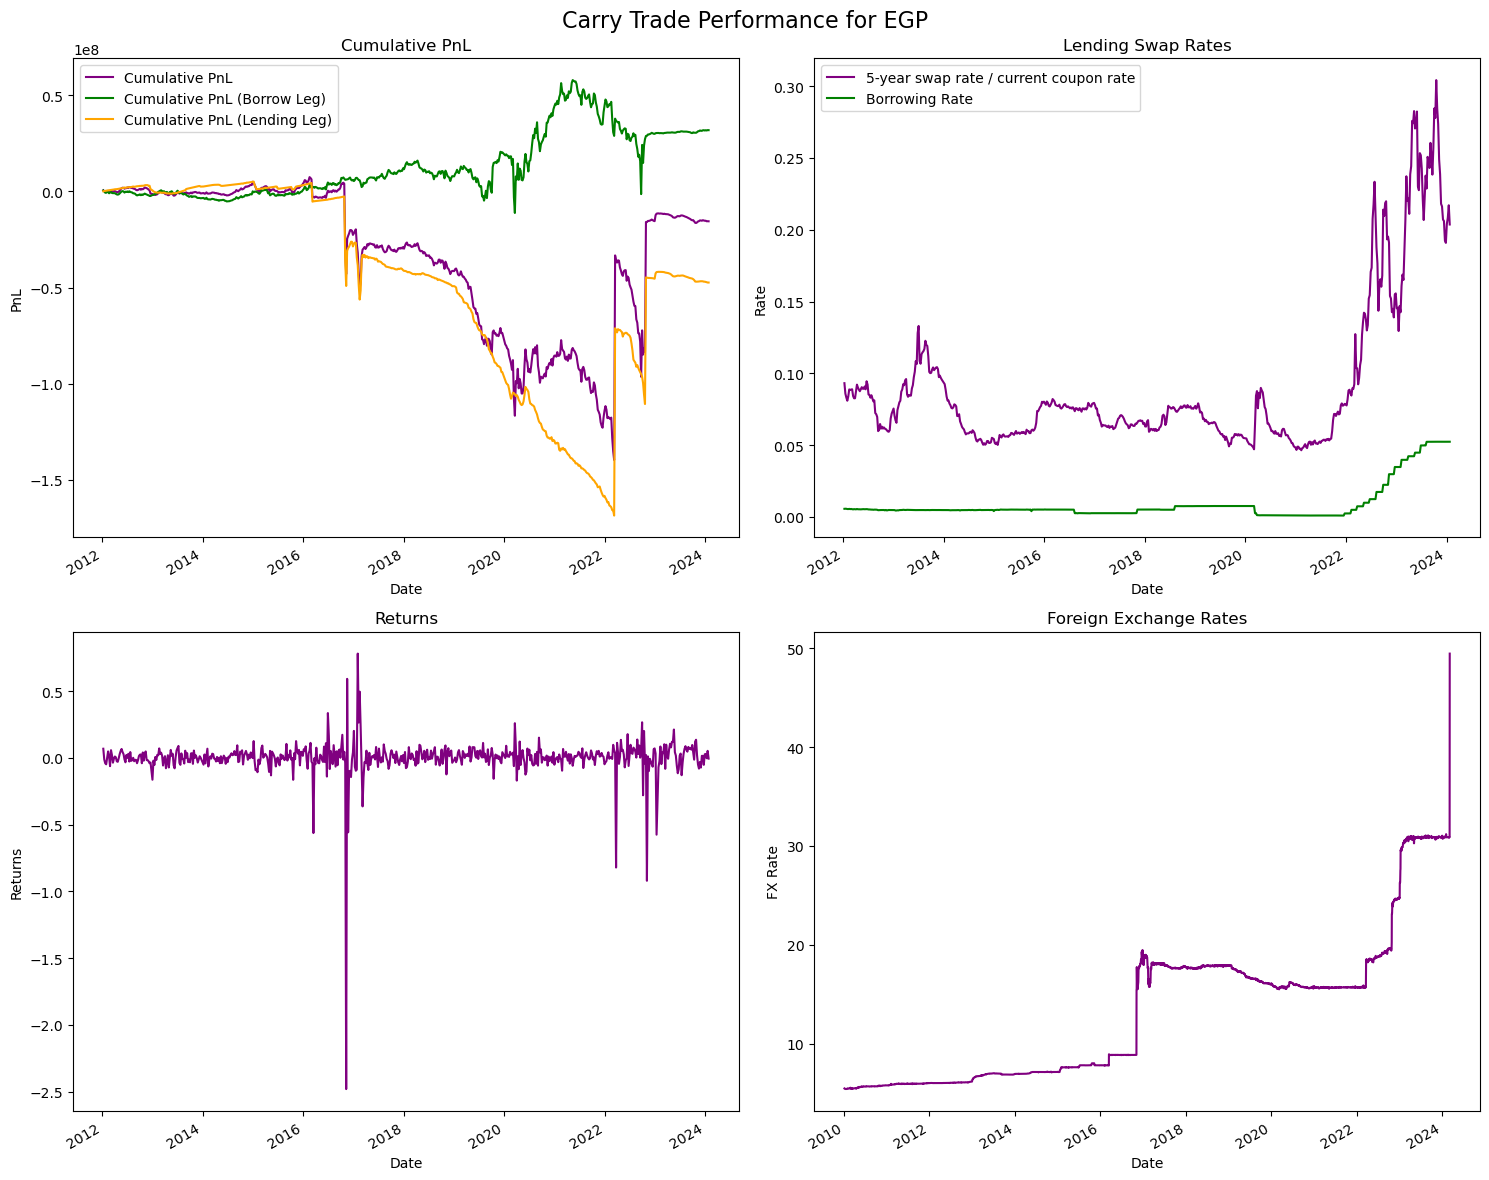

In [64]:
plot_carry_trades(carry_trade_EGP, 'EGP')

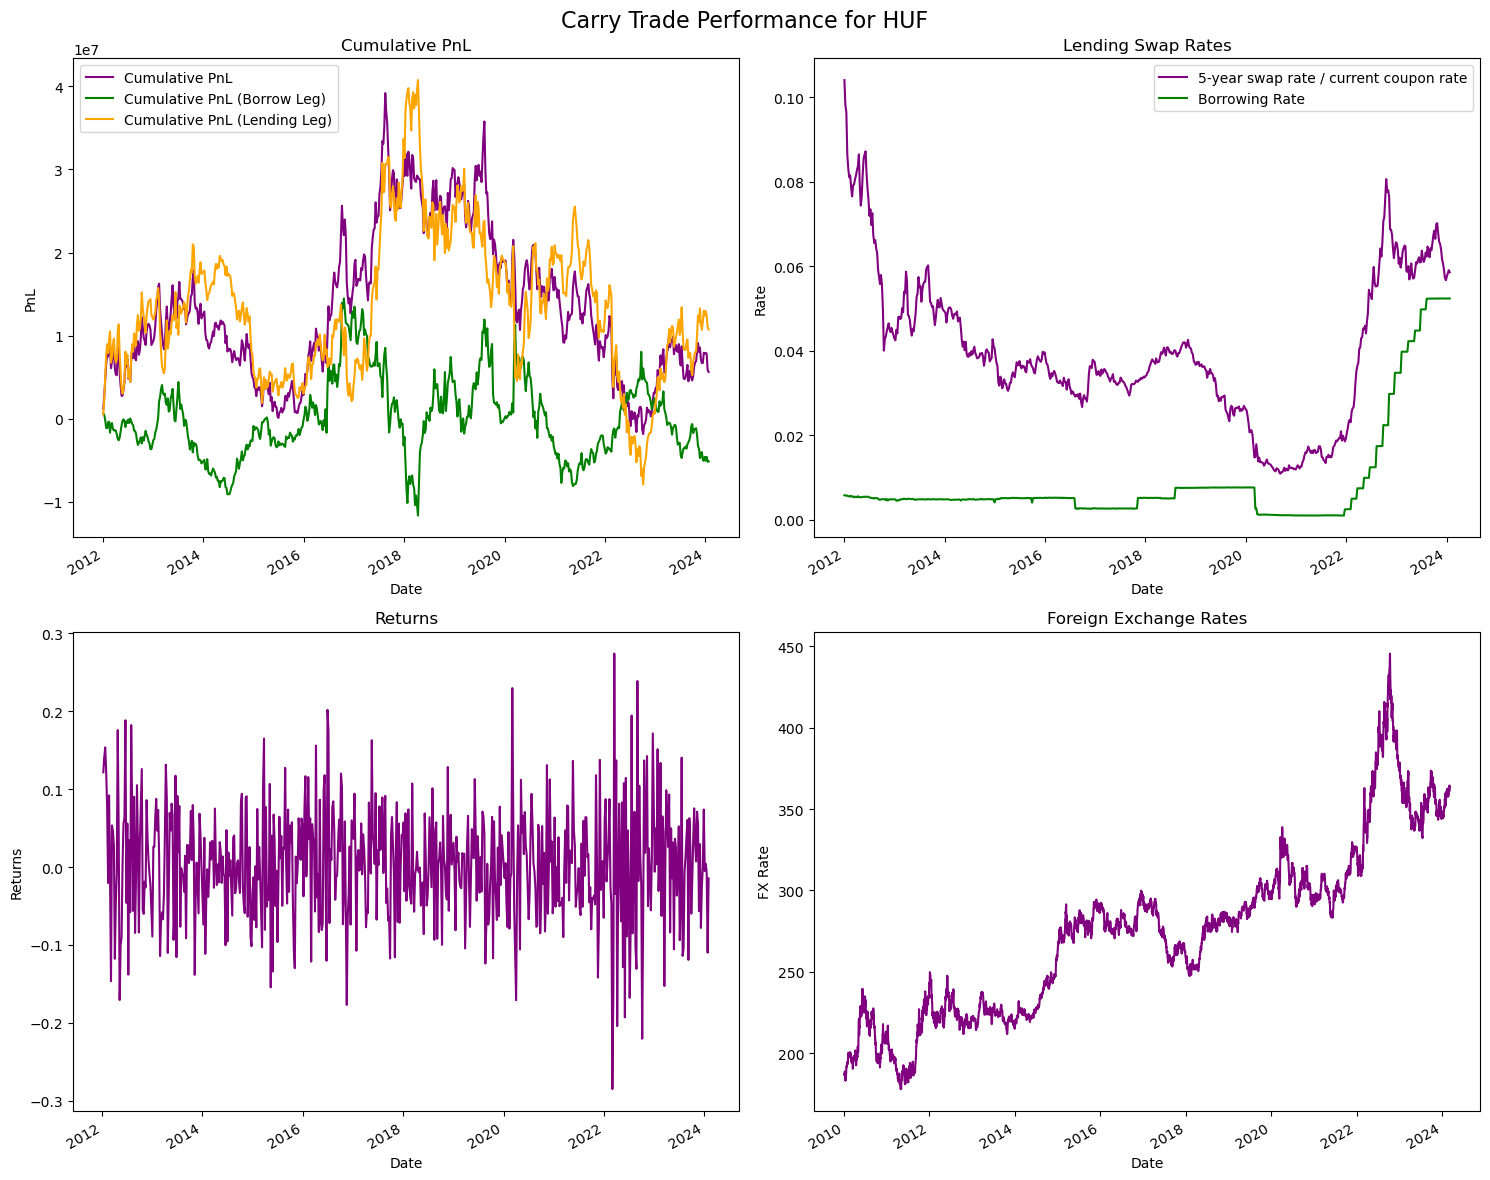

In [65]:
plot_carry_trades(carry_trade_HUF, 'HUF')

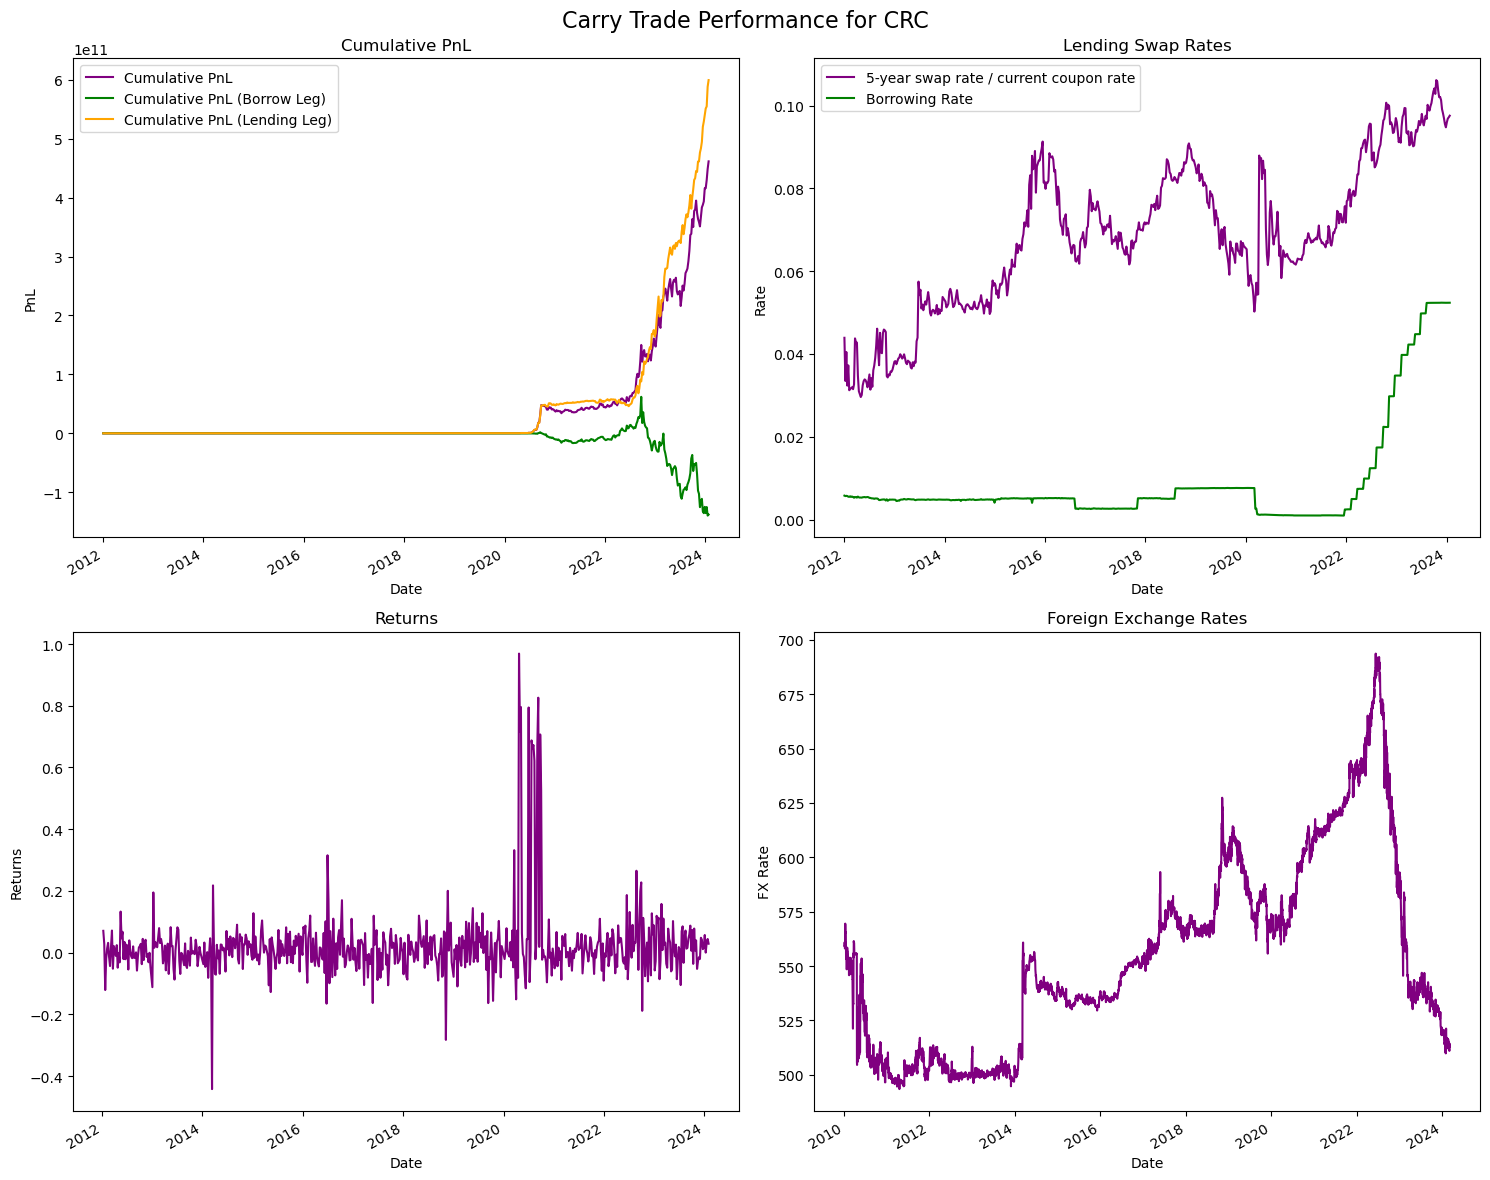

In [66]:
plot_carry_trades(carry_trade_CRC, 'CRC')

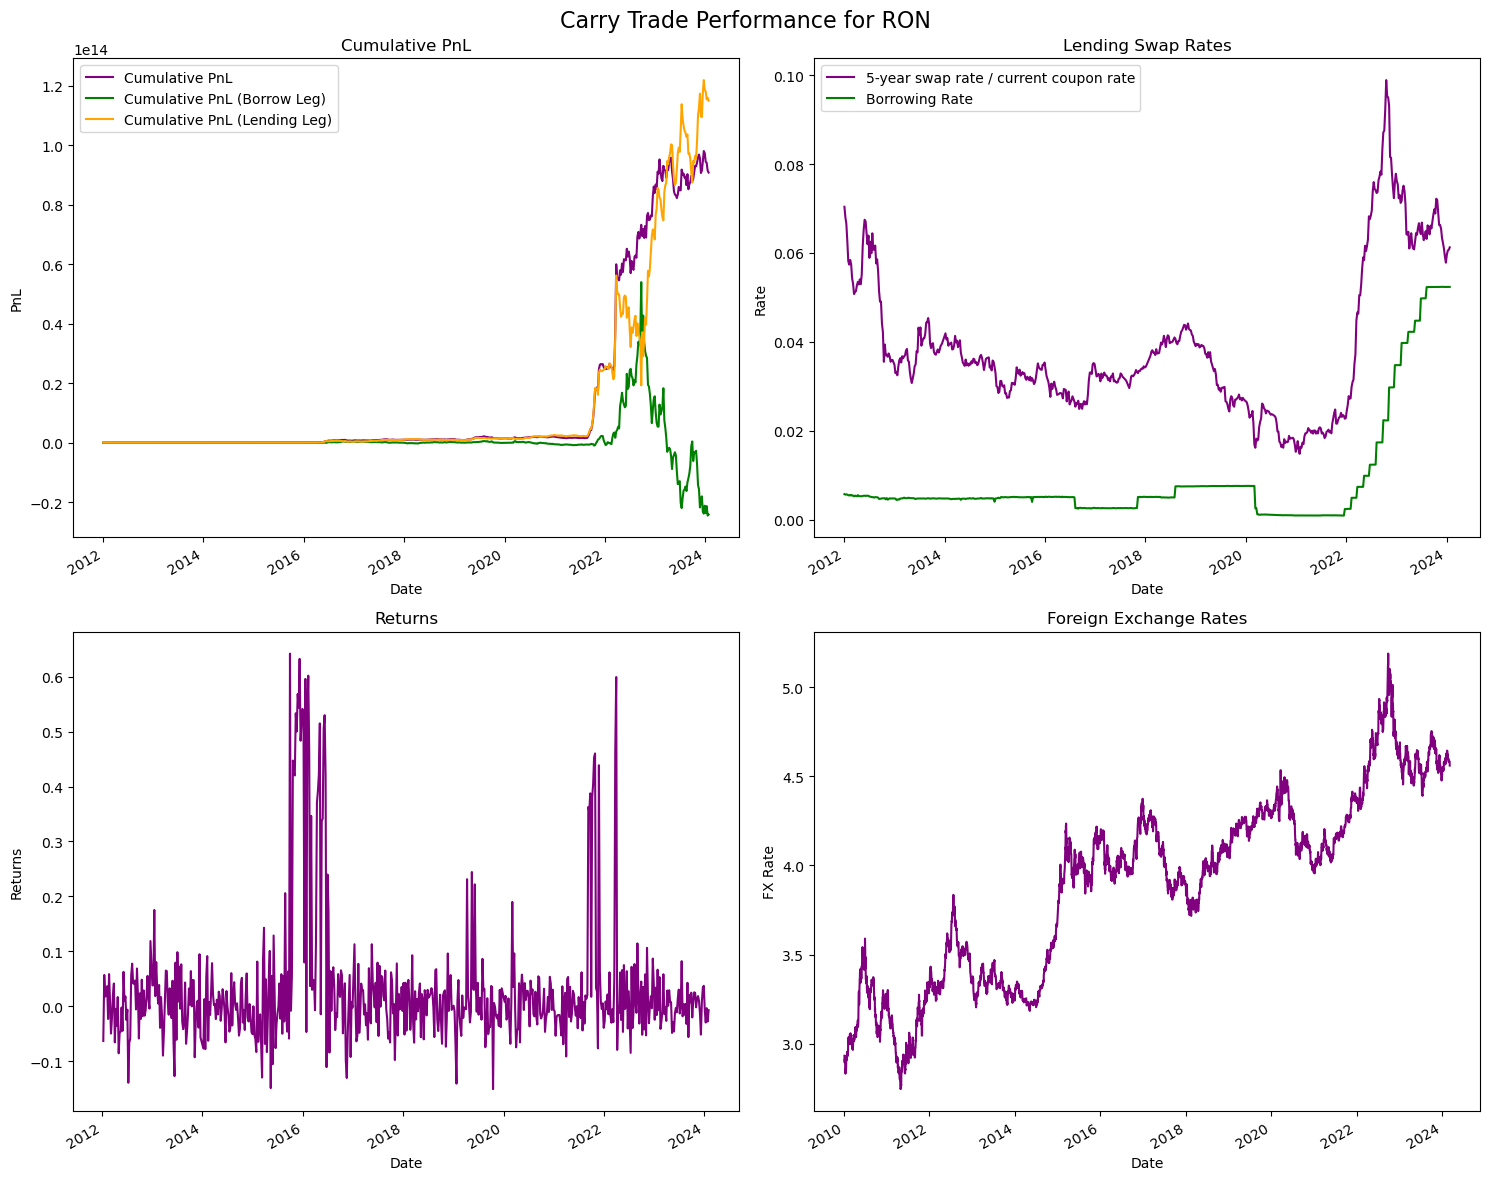

In [67]:
plot_carry_trades(carry_trade_RON, 'RON')

### 5 Return Analysis

In [38]:
def performance_summary(carry_trade, rf=None, annualization=52):
    returns = carry_trade['Returns'].to_frame()
    summary_stats = returns.mean().to_frame('Mean').apply(lambda x: x * annualization)
    summary_stats['Volatility'] = returns.std().apply(lambda x: x * np.sqrt(annualization))

    if rf is not None:
        summary_stats['Sharpe Ratio'] = (returns - rf).mean() / summary_stats['Volatility'] * annualization
    else:
        summary_stats['Sharpe Ratio'] = summary_stats['Mean'] / summary_stats['Volatility']

    summary_stats['Skewness'] = returns.skew()
    summary_stats['Excess Kurtosis'] = returns.kurtosis()
    summary_stats['Empirical VaR (0.05)'] = returns.quantile(.05, axis=0)

    wealth_index = 1000 * (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Return on Capital'] = str((carry_trade.iloc[-1]['Return on Capital'] * 100).round(2)) + '%'
    return summary_stats

In [60]:
carry_trade_dfs = [carry_trade_EGP, carry_trade_HUF, carry_trade_CRC, carry_trade_RON] 
return_analysis = []

for carry_trade_df in carry_trade_dfs:
    new_row = performance_summary(carry_trade_df)
    return_analysis.append(new_row)

return_analysis = pd.concat(return_analysis, ignore_index=True)
return_analysis.index = ['EGP', 'HUF', 'CRC', 'RON']
return_analysis

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Empirical VaR (0.05),Max Drawdown,Return on Capital
EGP,0.126679,1.015845,0.124703,-9.435081,162.347408,-0.086831,-8.438820,-55.04%
HUF,0.170522,0.515803,0.330595,0.034912,0.750959,-0.111211,-0.833974,156.33%
CRC,1.182054,0.847060,1.395478,4.231971,25.861882,-0.081766,-0.608418,4616462.2%
RON,1.667640,0.887746,1.878511,2.944772,9.192654,-0.068399,-0.529210,908418031.89%


By inspection of performance summaries of each currencies carry trade strategy, lending legs on some currencies are more profitable than others as seen in the difference between whopping returns of capital as high as 900 billion percent to a cumulative downside return of almost half its capital. The varying volatilities all surpasses that of market benchmark S&P 500 (~18%) on average and evne after the wide range of annual returns are factors, Sharpe ratios (2.24) may pose doubts for investors interested in sustainable gains across years. 

Carry trades with different currencies have their own characteristics that may only be accounted for by state-specifc economic conditions at the time. Although trends for borrowing rates are the similar across all currencies in terms of pandemic rate cut and post-pandemic anti-inflation rate hike, varying exchange rates contribute to the drastic different PnLs on lending legs. 
For both CRC and RON, later fruitful returns can be attributed to roaring foreign exchange rates. 

Carry trade strategy overall produces positive excess kurtosis and return distribution is culprit to extremes. Investors with conservative risk prefernces should be cautious as maximum drawdown can reach more than 80% in weekly returns. 

### 6 Fama-French Analysis

In [41]:
fama_french = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3)
fama_french = fama_french[:-1]
fama_french['Unnamed: 0'] = pd.to_datetime(fama_french['Unnamed: 0'], format='%Y%m%d')
fama_french.rename(columns={'Unnamed: 0': 'date'}, inplace=True)
fama_french.set_index('date', inplace=True)
fama_french = fama_french.fillna(method='ffill')

fama_french = fama_french["2010-01-06":"2024-01-31"]

In [42]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [43]:
def fama_french_analysis(fama_french_in, carry_trade_df_in):

    fama_french_strat = fama_french_in.merge(carry_trade_df_in, left_index=True, right_index=True)
    reg = regression_based_performance(fama_french_strat[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']],fama_french_strat['Returns'],0)
    beta_mkt = reg[0][0]
    beta_smb = reg[0][1]
    beta_hml = reg[0][2]
    beta_rmw = reg[0][3]
    beta_cma = reg[0][4]

    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    portfolio_summary = pd.DataFrame([[beta_mkt, beta_smb, beta_hml,beta_rmw, beta_cma, treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Size Beta', 'Value Beta','Profitability Beta','Investment Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'], index =['Portfolio'])
    return portfolio_summary

In [44]:
fama_french_analysis_df = []
for carry_trade_df in carry_trade_dfs:
    new_row = fama_french_analysis(fama_french, carry_trade_df)
    fama_french_analysis_df.append(new_row)

fama_french_analysis_df = pd.concat(fama_french_analysis_df, ignore_index=True)
fama_french_analysis_df.index = ['EGP', 'HUF', 'CRC', 'RON']
fama_french_analysis_df

,Market Beta,Size Beta,Value Beta,Profitability Beta,Investment Beta,Treynor Ratio,Information Ratio,Alpha,R-Squared
EGP,-0.001162,-0.007898,-0.005904,0.022483,-0.044604,-24.511012,-0.007124,-0.003432,0.029181
HUF,0.005185,-0.000720,-0.004521,0.000312,0.006063,7.352367,0.109361,0.027084,0.005918
CRC,0.012725,0.008533,-0.028000,0.040015,0.003595,21.369516,0.701501,0.279036,0.050455
RON,0.004915,-0.001436,-0.005586,-0.006578,0.011518,78.621260,1.202448,0.509088,0.020377


In [45]:
fama_french_strat_combined = fama_french.merge(carry_trade_EGP['Returns'], left_index=True, right_index=True)
fama_french_strat_combined = fama_french_strat_combined.merge(carry_trade_HUF['Returns'], left_index=True, right_index=True)
fama_french_strat_combined = fama_french_strat_combined.merge(carry_trade_CRC['Returns'], left_index=True, right_index=True)
fama_french_strat_combined = fama_french_strat_combined.merge(carry_trade_RON['Returns'], left_index=True, right_index=True)

/var/folders/zq/3znm38ld5sq9yk3f706q0l9r0000gp/T/ipykernel_27392/3961040325.py:4: FutureWarning: Passing 'suffixes' which cause duplicate columns {'Returns_x'} in the result is deprecated and will raise a MergeError in a future version.


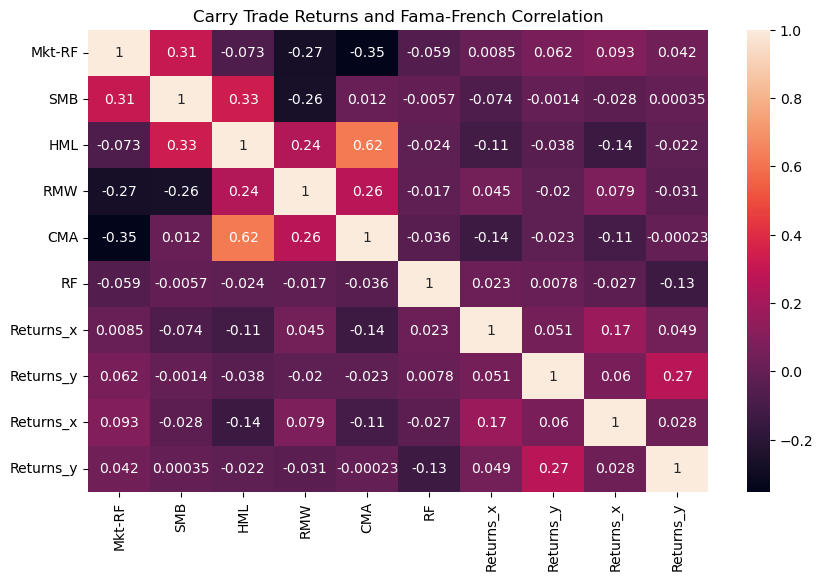

In [46]:
plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(fama_french_strat_combined.corr(), annot=True)
plt.title('Carry Trade Returns and Fama-French Correlation')
plt.show()

Theoretically carry trades is not a pure alpha strategy and correlate with market returns. However a simple Fama-French analysis indicates that not only do carry trade strategies returns have a slightly negative correlation, they also produce minor alphas. R-squared values indicate Fama-French explain very little variations among carry-trade strategy returns (<5%)

### 7 Conclusions

Carry trade strategies have three main sources of risks: inflation risks causing fluctuations among payback amount, OIS rate variation on borrowing leg and foreign exchange spot rates changes. Through implementation and analysis of this strategy on three currencies Egyptian Pound, Hungarian
Forint, Costa Rican Colon and Romanian Leu we can conclude that interest rate difference between countries can be utilized for an slightly anti-cyclical strategy that produce significant return on capital with slight risks for extreme returns on the negative ends. 